# DC Bias and AC Perturbation Analysis# 


This notebook summarizes the tests I ran on 6/8/2018 to determine if higher applied DC bias or higher AC perturbation can mitigate the weird mid frequency half arc feature we see in the data. The hope is that higher DC bias may make the data more linear. As a result, we can drive the system with higher AC signal to minimize noise. 

Alternatively, it's possible that we are driving the system too hard. In that case, we need to scale back the DC bias and AC signal. 

I won't try and fit the data to start; let's just see if the data have an apparent trend with DC bias.

In [11]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [16]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\impedance\PbS-TBAI\ZnO_3\bias_test')

# os.listdir()
ampMax = 6
amp = np.linspace(10,10+(20*ampMax),ampMax,endpoint=False)
devNum = 2
voltage1 = 300
voltage2 = 500
voltage3 = 700

nPoints = 201
master300mv = np.zeros((ampMax,nPoints,5))
master500mv = np.zeros((ampMax,nPoints,5))
# master700mv = np.zeros((ampMax,nPoints,5))

is300 = np.zeros((ampMax,nPoints,4))
is500 = np.zeros((ampMax,nPoints,4))
# is700 = np.zeros((ampMax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for a in range(0,ampMax):
    file1 = 'dev' + str(devNum) + '_' + str(voltage1) + 'mV_' + np.array2string(amp[a].astype(int)) + 'mVamp_T300K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master300mv[a,:,0] = tmp1[1:,0]
    master300mv[a,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master300mv[a,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master300mv[a,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master300mv[a,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is300[a,:,0] = ((master300mv[a,:,4]/((master300mv[a,:,4]**2) + (master300mv[a,:,2]**2)))*4e-2)/1e3
    is300[a,:,1] = ((-master300mv[a,:,2]/((master300mv[a,:,4]**2) + (master300mv[a,:,2]**2)))*4e-2)/1e3
    is300[a,:,2] = np.sqrt((is300[a,:,0]**2) + (is300[a,:,1]**2))
    is300[a,:,3] = -np.arctan(is300[a,:,1]/is300[a,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_' + str(voltage2) + 'mV_' + np.array2string(amp[a].astype(int)) + 'mVamp_T300K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[a,:,0] = tmp2[1:,0]    
    master500mv[a,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[a,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[a,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[a,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[a,:,0] = ((master500mv[a,:,4]/((master500mv[a,:,4]**2) + (master500mv[a,:,2]**2)))*4e-2)/1e3
    is500[a,:,1] = ((-master500mv[a,:,2]/((master500mv[a,:,4]**2) + (master500mv[a,:,2]**2)))*4e-2)/1e3
    is500[a,:,2] = np.sqrt((is500[a,:,0]**2) + (is500[a,:,1]**2))
    is500[a,:,3] = -np.arctan(is500[a,:,1]/is500[a,:,0])*(180/np.pi)
    

# define some simple functions to make the analysis code a bit more concise
def Zr300(A):
    return is300[A,:,0]

def Zr500(A):
    return is500[A,:,0]

def Zi300(A):
    return is300[A,:,1]

def Zi500(A):
    return is500[A,:,1]

def Zmag300(A):
    return is300[A,:,2]

def Zmag500(A):
    return is500[A,:,2]

def phi300(A):
    return is300[A,:,3]

def phi500(A):
    return is500[A,:,3]

def w(A):
    return master300mv[A,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,ampMax)))

# indicate the figures directory
figDir = r'C:\Users\Eric\Desktop\Lab_Work\impedance\PbS-TBAI\ZnO_3\analysis'

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1


# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst300 = np.zeros(ampMax)
RsEst500 = np.zeros(ampMax)

for a in range (0,ampMax): 
    RsEst300[a] = Zr300(a)[-1]
    RsEst500[a] = Zr500(a)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def Zmag300adj(A):
    return np.sqrt(((is300[A,:,0]-RsEst300[A])**2) + (is300[A,:,1]**2))

def Zmag500adj(A):
    return np.sqrt(((is500[A,:,0]-RsEst500[A])**2) + (is500[A,:,1]**2))

def phi300adj(A):
    return -np.arctan(is300[A,:,1]/(is300[A,:,0]-RsEst300[A]))*(180/np.pi)

def phi500adj(A):
    return -np.arctan(is500[A,:,1]/(is500[A,:,0]-RsEst500[A]))*(180/np.pi)

First look at the 300mV data

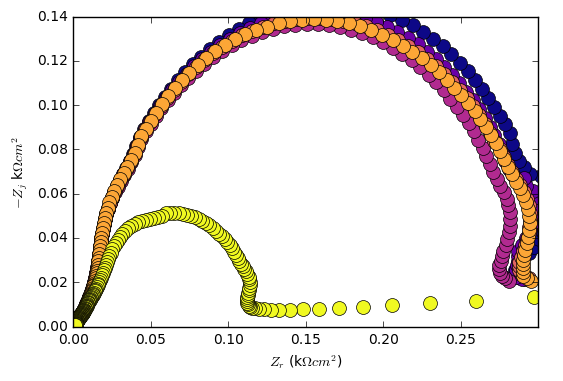

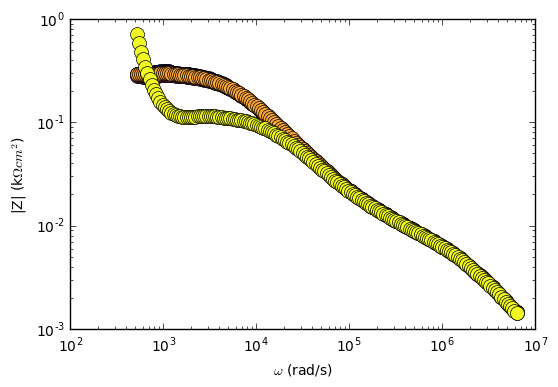

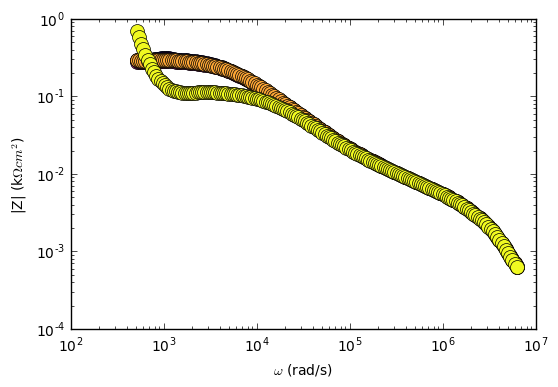

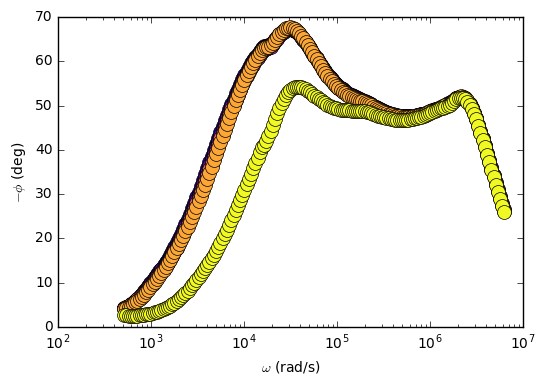

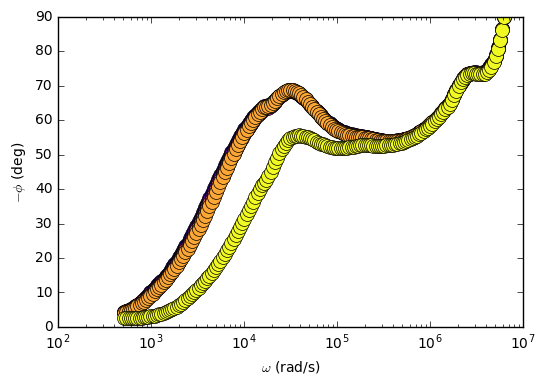

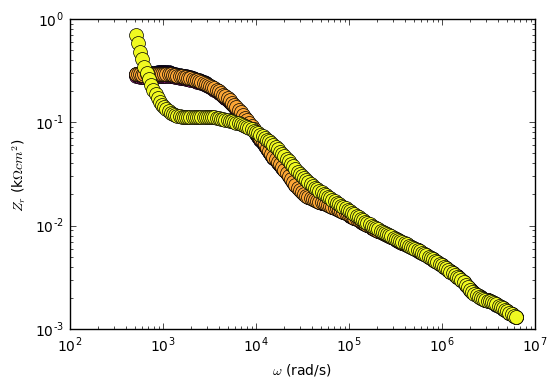

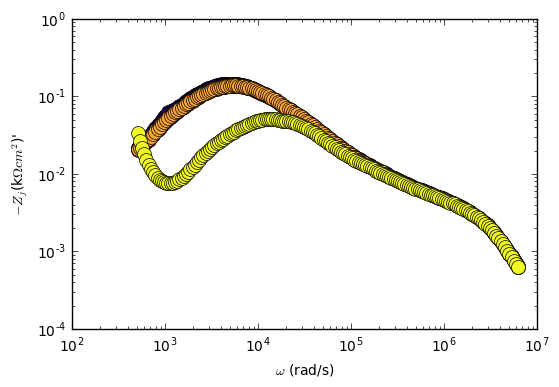

In [23]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(Zr300(a),-Zi300(a),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.3, 0,.14])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag300(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag300adj(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi300(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi300adj(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zr300(a),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),abs(-Zi300(a)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

Now try the 500 mV data

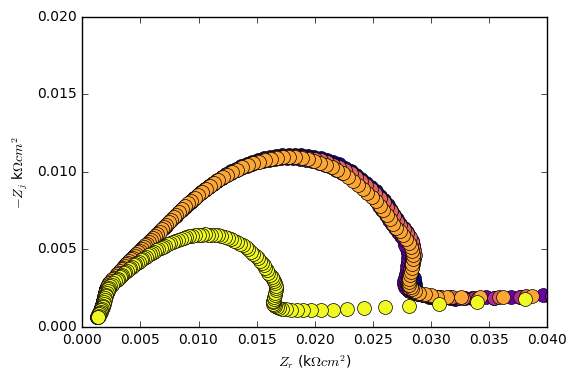

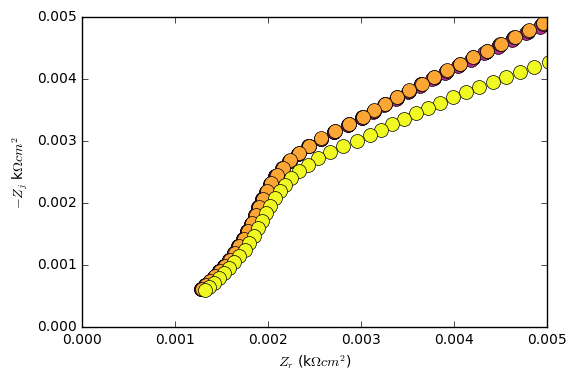

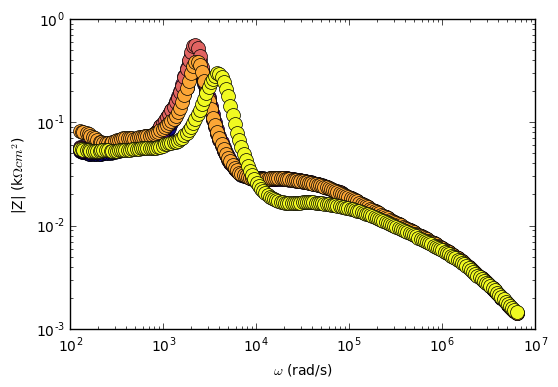

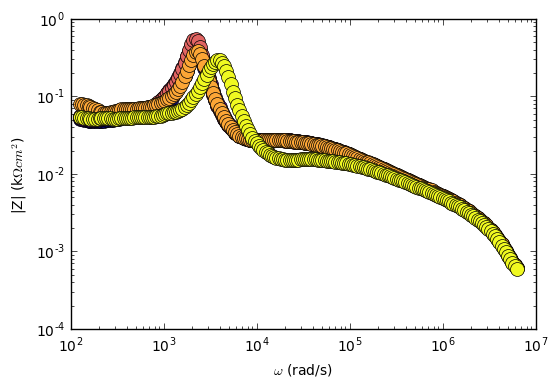

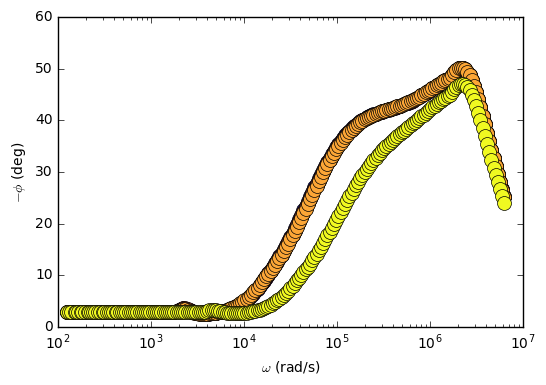

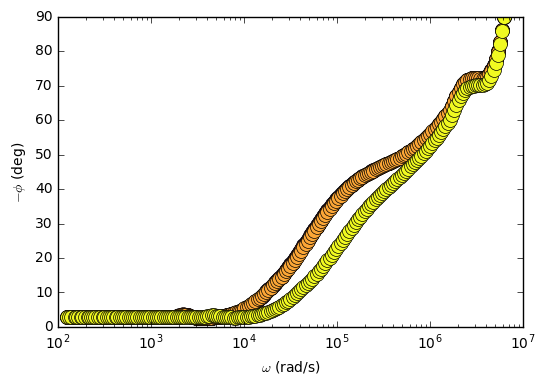

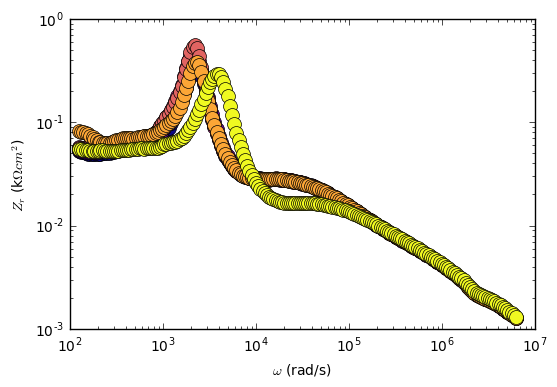

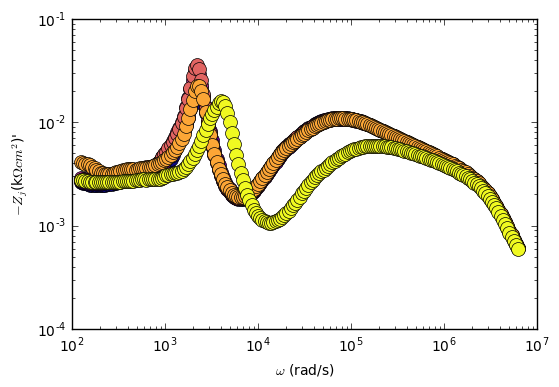

In [25]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(Zr500(a),-Zi500(a),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.04, 0,0.02])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Nyquist plots
fig,ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(Zr500(a),-Zi500(a),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.005, 0,0.005])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag500(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag500adj(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi500(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi500adj(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zr500(a),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),abs(-Zi500(a)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

Try the 700 mV data set

In [26]:
print(voltage3)

700


In [29]:
os.chdir(r'C:\Users\Eric\Desktop\Lab_Work\impedance\PbS-TBAI\ZnO_3\bias_test\remeasure700mV')

master700mv = np.zeros((ampMax,nPoints,5))
is700 = np.zeros((ampMax,nPoints,4))

for a in range(0,ampMax):
    file3 = 'dev' + str(devNum) + '_' + np.array2string(amp[a].astype(int)) + 'mVamp_T300K_Vbias' + str(voltage3) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file3)
    master700mv[a,:,0] = tmp1[1:,0]
    master700mv[a,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master700mv[a,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master700mv[a,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master700mv[a,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is700[a,:,0] = ((master700mv[a,:,4]/((master700mv[a,:,4]**2) + (master700mv[a,:,2]**2)))*4e-2)/1e3
    is700[a,:,1] = ((-master700mv[a,:,2]/((master700mv[a,:,4]**2) + (master700mv[a,:,2]**2)))*4e-2)/1e3
    is700[a,:,2] = np.sqrt((is700[a,:,0]**2) + (is700[a,:,1]**2))
    is700[a,:,3] = -np.arctan(is700[a,:,1]/is700[a,:,0])*(180/np.pi)
                           
def Zr700(A):
    return is700[A,:,0]

def Zi700(A):
    return is700[A,:,1]

def Zmag700(A):
    return is700[A,:,2]

def phi700(A):
    return is700[A,:,3]

# Estimate $R_{s}$ by taking the highest frequency value of $Z_{r}$
RsEst700 = np.zeros(ampMax)

for a in range (0,ampMax): 
    RsEst700[a] = Zr700(a)[-1]
    
# define functions to output the magnitude and phase angle of the Rs-corrected plots.   
def Zmag700adj(A):
    return np.sqrt(((is700[A,:,0]-RsEst700[A])**2) + (is700[A,:,1]**2))

def phi700adj(A):
    return -np.arctan(is700[A,:,1]/(is700[A,:,0]-RsEst700[A]))*(180/np.pi)

    

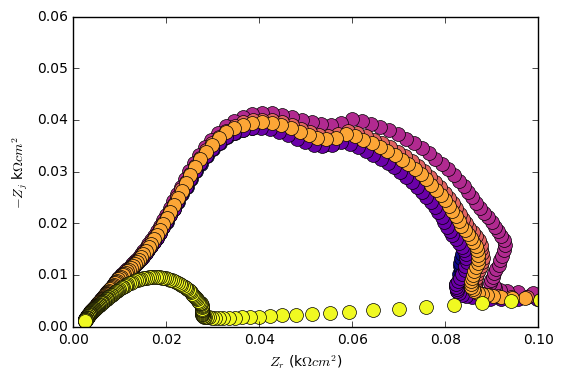

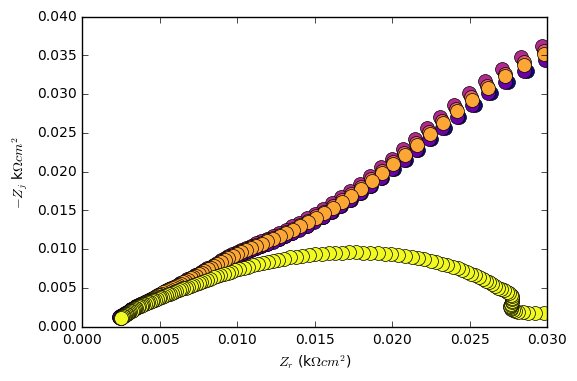

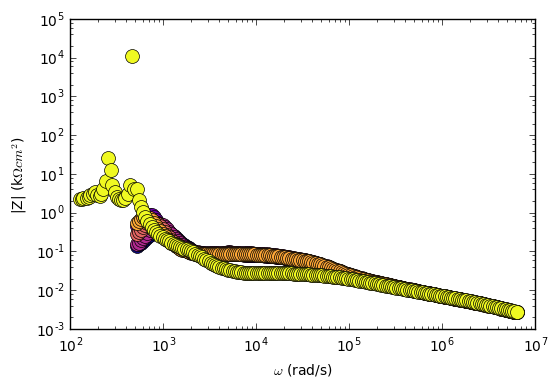

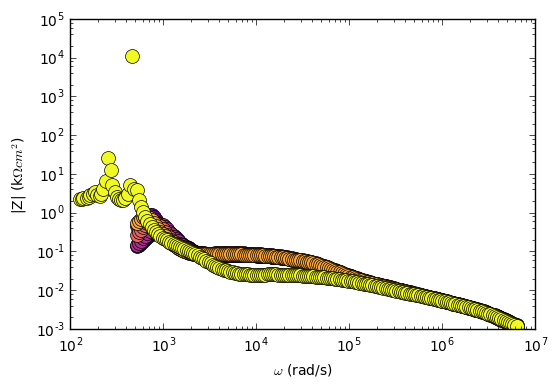

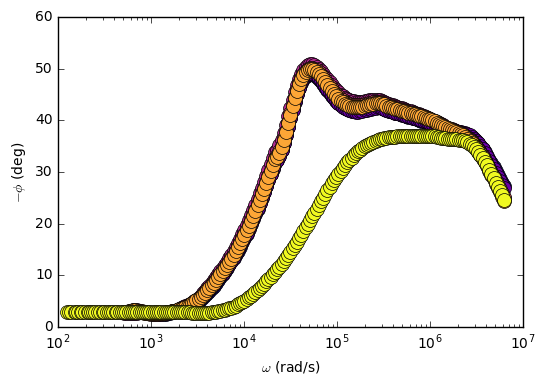

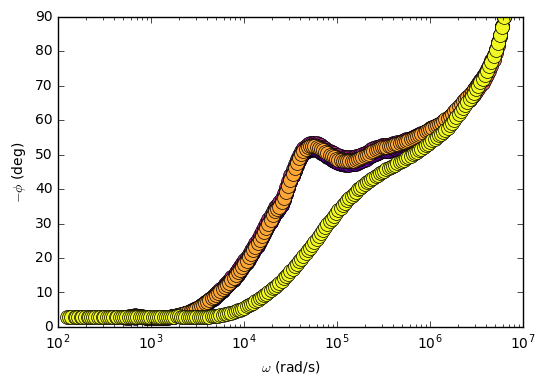

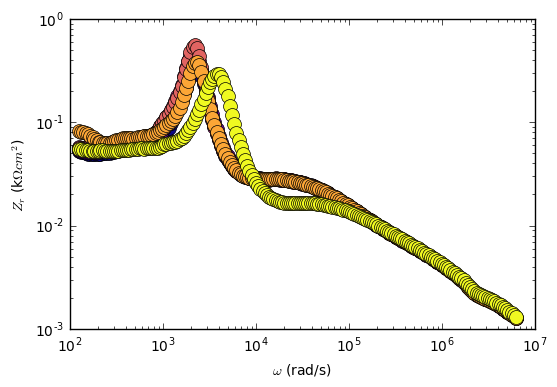

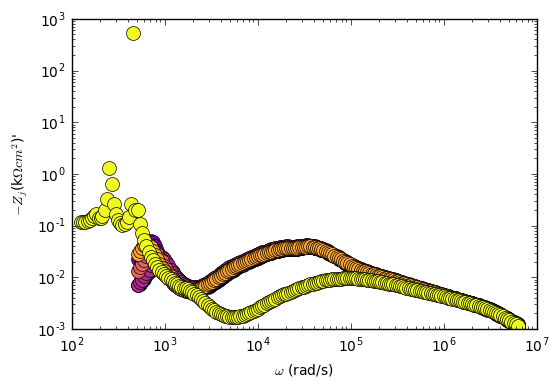

In [37]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(Zr700(a),-Zi700(a),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.1, 0,0.06])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Nyquist plots
fig,ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(Zr700(a),-Zi700(a),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,0.03, 0,0.04])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag700(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z|_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zmag700adj(a),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("$|Z|_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZadj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi700(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi_{adj} vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),phi700adj(a),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi_{adj}$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phaseAdj_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),Zr500(a),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for a,c in zip(range(0,ampMax),colSet):
    ax.plot(w(a),abs(-Zi700(a)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

So what can we discern from this data?

1) DC bias matters! From Bisquert ([10.1021/jp9037649](https://pubs.acs.org/doi/abs/10.1021/jp9037649)), we know that when there is a significant depletion region, the lifetime we obtain does not probe recombination lifetime. This is because the data contain information about dieledtric relaxation of carriers in the depletion region in the capacitance, which dominates over any recombination signal. Also note that this is why we obtained the same activation energy in TAS and IS measurements for the 400 mV data run thus far!

Clearly, as we jack up the bias, we see a smaller arc that looks ver much like a CPE with slightly sub-normal diffusion (i.e. anomalous diffusion...). We think the same distribution of lifetimes gives rise to these features. 

To summarize, DC bias let's us **access different regimes in the IS measurement**

2) There is a slight dependence on AC ampltiude. From the Orazem textbook,we expect that for very linear *JV* curves, we should be able to drive the system with very large perturbations. We need to check this somewhat numerically, as there is a big jump between $V_{RMS} = 90 mV$ and $V_{RMS} = 110mV$ in all of the measurements. Note, however, that in the measurements obtained at $V_{DC} = 500,900 mV$, **no** noise appears in the curves. We seem to have smoothed out whatever the strange feature that appears at $\approx 10^{5}$ rad/s by using this large AC amplitude.

From qualitiative analysis, it seems like driving the system at $V_{RMS} = 110 mV$ may inadvertantly change current response of the system. 

